# Circular Building Pit

Comparing TimML solutions with `LeakyLineDoublets` and `LeakyBuildingPit` to the exact
analytical solution for a circular building pit in a semi-confined aquifer.

In [1]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from scipy.special import i0, i1, k0, k1

import timml as tml

Select a radius for the circular building pit.

In [2]:
R = 100.0  # radius of building pit

Specify a resolution to control the number of leaky segments used in the TimML models to approximate the exact  analytical solution.

In [3]:
# subdivide circle into segments, increase resolution to increase no. of elements
resolution = 5  # resolution=5 results in 20 segments
circle = shapely.Point(0, 0).buffer(R, resolution=resolution)
print("Number of pts      :", len(circle.exterior.xy[0]))
print("Number of segments :", len(circle.exterior.xy[0]) - 1)

Number of pts      : 21
Number of segments : 20


Show the points used to approximate the circular building pit. 

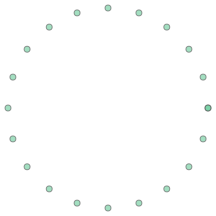

In [4]:
shapely.MultiPoint(shapely.points(shapely.get_coordinates(circle)))

To create our model we create a list of x,y-coordinates, ordered counter-clockwise.

In [5]:
# flip so coordinates are ordered counter clockwise
xy = list(
    zip(
        shapely.get_coordinates(circle)[:, 0],
        shapely.get_coordinates(circle)[:, 1],
    )
)[::-1]

Define model parameters:
- horizontal and vertical hydraulic conductivity in m/d
- top resistance of semi-confined aquifer in days 
- top and bottom elevations of the aquifer
- resistance of the leaky wall in days
- order of the elements in TimML (which specifies the no. of control points used in the solution)

In [6]:
# model parameters

kh = 10  # m/day
kv = 0.25 * kh  # m/day

ctop = 1000.0  # resistance top leaky layer in days

ztop = 0.0  # surface elevation
zbot = -20.0  # bottom elevation of the model
z = np.array([ztop + 1, ztop, zbot])

res = 100.0  # resistance of leaky wall, in days

rw = 0.3  # well radius, in m
Qw = 100.0  # well discharge, in m3/d

o = 7  # order

Build a TimML model with a circular building pit using the `LeakyLineDoubletString` 
element. The building pit contains a well at location $(0, 0)$ with a discharge of 100 $m^3/d$.

In [7]:
ml_lld = tml.ModelMaq(kaq=kh, z=z, c=ctop, topboundary="semi", hstar=0.0)
lld = tml.LeakyLineDoubletString(
    ml_lld,
    xy=xy,
    res=res,
    layers=[0],
    order=o,
)
well = tml.Well(ml_lld, 0.0, 0.0, Qw=Qw, rw=rw)
ml_lld.solve()

Number of elements, Number of equations: 3 , 160
...
solution complete


Next we build the same model, but using the `LeakyBuildingPit` element. This element
is technically an inhomogeneity (allowing different aquifer parameters inside the 
element as compared to the rest of the model), but for comparison purposes we keep 
the aquifer homogeneous. 

In [8]:
ml = tml.ModelMaq(kaq=kh, z=z, c=ctop, topboundary="semi", hstar=0.0)
bpit = tml.LeakyBuildingPitMaq(
    ml,
    xy,
    kaq=kh,
    z=z,
    topboundary="semi",
    hstar=0.0,
    c=ctop,
    layers=[0],
    res=res,
    order=o,
)
well = tml.Well(ml, 0.0, 0.0, Qw=Qw, rw=rw)
ml.solve()

Number of elements, Number of equations: 43 , 320
...........................................
solution complete


Calculate the exact analytical solution. 

In [9]:
# translate some of the model parameters defined earlier
k = kh  # m/d
H = ztop - zbot  # m
c = ctop  # d
cwall = res  # d
Q = Qw  # m^3/d

# computed values
T = k * H
lab = np.sqrt(c * T)
C = H * lab / (cwall * T)
I0 = i0(R / lab)
I1 = i1(R / lab)
K0 = k0(R / lab)
K1 = k1(R / lab)
B = -Q * (K1 * I0 + I1 * K0) / (K0 * I1 + K1 * I0 + I1 * K1 / C)
A = -(Q + B) * K1 / I1

Define functions for the head and discharge as a function of the radial distance $r$.

In [10]:
def head_nowall(r):  # for comparison
    return -Q / (2 * np.pi * T) * k0(r / lab)


def head(r):
    if r < R:
        h = -Q / (2 * np.pi * T) * k0(r / lab) + A / (2 * np.pi * T) * i0(r / lab)
    else:
        h = B / (2 * np.pi * T) * k0(r / lab)
    return h


def disr(r):
    if r < R:
        Qr = -Q / (2 * np.pi * lab) * k1(r / lab) - A / (2 * np.pi * lab) * i1(r / lab)
    else:
        Qr = B / (2 * np.pi * lab) * k1(r / lab)
    return Qr


headvec = np.vectorize(head)
disrvec = np.vectorize(disr)

Plot the analytical solution for the head (left) and radial discharge (right) as a function of radial distance $r$.

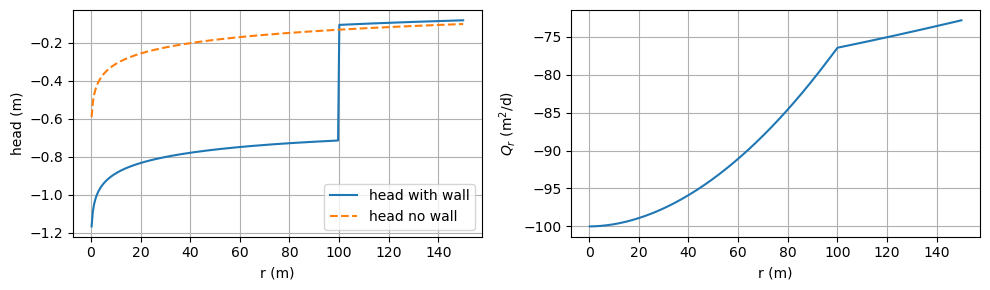

In [11]:
r = np.linspace(rw, 1.5 * R, 301)
h = headvec(r)
Qr = disrvec(r) * 2 * np.pi * r
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.plot(r, h, label="head with wall")
plt.plot(r, head_nowall(r), "--", label="head no wall")
plt.xlabel("r (m)")
plt.ylabel("head (m)")
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(r, Qr)
plt.xlabel("r (m)")
plt.ylabel("$Q_r$ (m$^2$/d)")
plt.grid()
plt.tight_layout()

Now let's compare the exact analytical solution to the TimML models from earlier.

We specify the angle of the line relative to the positive x-axis along which the heads (and radial discharge) are computed in the TimML models. At the endpoints the radius of the building pit is exactly equal to $R$, whereas in between two endpoints, the radius is slightly smaller. The TimML solutions at the endpoints can show some deviations from the exact solution. 

In [12]:
angle = 0.0  # in degrees

First we compare the head. In the top plot, the heads are plotted as a function of radial distance $r$. In the second plot the differences between the TimML models and the exact solutions are shown.

The models correspond closely to the exact solution with differences on the order of $10^{-3}$ inside the building pit, and even smaller outside the building pit. The TimML model with the `LeakyBuildingPit` element is slightly more accurate than the `LeakyLineDoublet` solution, though differences are small. 

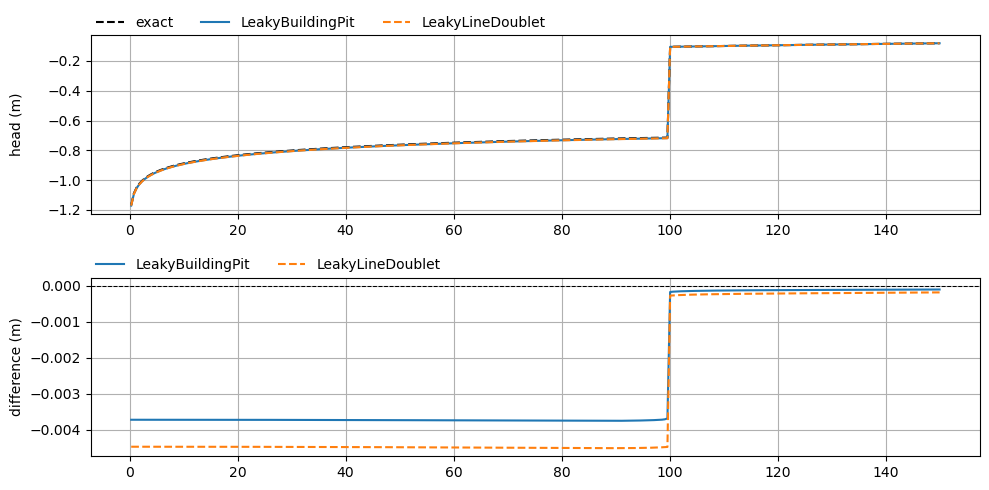

In [13]:
r = np.linspace(rw, 1.5 * R, 301)

sin = np.sin(np.deg2rad(angle))
cos = np.cos(np.deg2rad(angle))
xl = np.linspace(rw * cos, cos * 1.5 * R, 301)
yl = np.linspace(rw * sin, sin * 1.5 * R, 301)
rl = np.sqrt((xl - 0.0) ** 2 + (yl - 0.0) ** 2)

h = headvec(r)
h_lld = ml_lld.headalongline(xl, yl)
h_lp = ml.headalongline(xl, yl)

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 5))
ax.plot(r, h, color="k", ls="dashed", label="exact")
ax.plot(r, h_lp.squeeze(), color="C0", label="LeakyBuildingPit")
ax.plot(r, h_lld.squeeze(), color="C1", ls="dashed", label="LeakyLineDoublet")
ax.legend(loc=(0, 1), ncol=3, frameon=False)
ax.set_ylabel("head (m)")
ax.grid(True)

ax2.axhline(0.0, linestyle="dashed", color="k", lw=0.75)
ax2.plot(r, h_lp.squeeze() - h, color="C0", label="LeakyBuildingPit")
ax2.plot(r, h_lld.squeeze() - h, color="C1", ls="dashed", label="LeakyLineDoublet")
ax2.legend(loc=(0, 1), ncol=3, frameon=False)
ax2.grid(True)
ax2.set_ylabel("difference (m)")
# ax2.set_ylim(-0.005, 0.005)

fig.align_ylabels()
fig.tight_layout()

Next, we compare the computed radial discharge between the TimML models and the exact solution.

The top plot shows the radial discharge, and the bottom plot shows the difference between the TimML models and the exact solution. At the wall the computed radial discharge differs from the exact solution. This is caused by the implementation of the elements in TimML, where control points along a line are specified at which (or between which) certain conditions must be satisfied. The solution at a particular point close to the element may not be entirely accurate. For the `LeakyBuildingPit` implementation, this results in the solution at the edges of the segments to become inaccurate. However, integrating the flux along the entire circular building pit should yield relatively accurate results for the radial discharge, as we will see in the next step. 

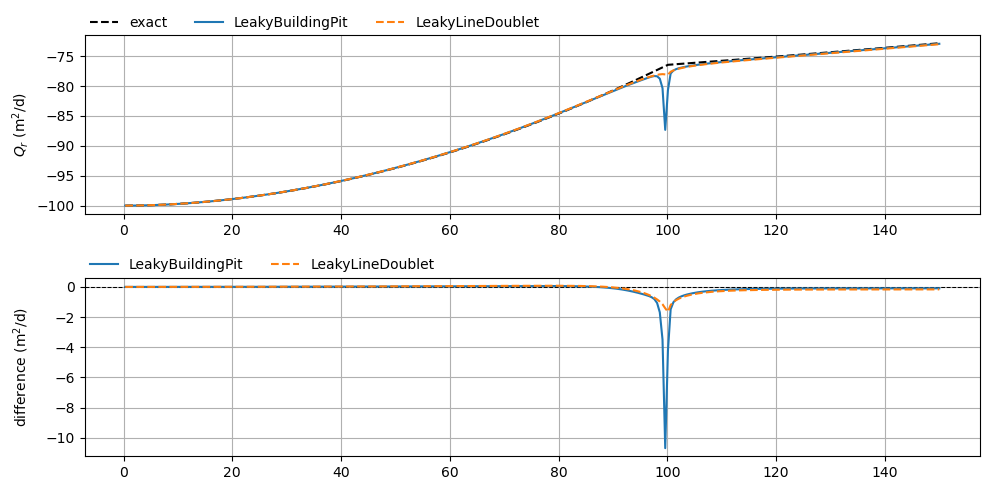

In [14]:
Qr = disrvec(r) * 2 * np.pi * r
qx_lld, qy_lld = ml_lld.disvecalongline(xl, yl)
qx_lp, qy_lp = ml.disvecalongline(xl, yl)

Q_lld = (qx_lld * cos + qy_lld * sin).squeeze() * 2 * np.pi * rl
Q_lp = (qx_lp * cos + qy_lp * sin).squeeze() * 2 * np.pi * rl

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 5))
ax.plot(r, Qr, color="k", ls="dashed", label="exact")
ax.plot(r, Q_lp.squeeze(), color="C0", label="LeakyBuildingPit")
ax.plot(r, Q_lld.squeeze(), color="C1", ls="dashed", label="LeakyLineDoublet")
ax.legend(loc=(0, 1), ncol=3, frameon=False)
ax.set_ylabel("$Q_r$ (m$^2$/d)")
ax.grid(True)

ax2.axhline(0.0, linestyle="dashed", color="k", lw=0.75)
ax2.plot(r, Q_lp.squeeze() - Qr, color="C0", label="LeakyBuildingPit")
ax2.plot(r, Q_lld.squeeze() - Qr, color="C1", ls="dashed", label="LeakyLineDoublet")
ax2.legend(loc=(0, 1), ncol=3, frameon=False)
ax2.grid(True)
ax2.set_ylabel("difference (m$^2$/d)")
# ax2.set_ylim(-0.25, 0.25)

fig.align_ylabels()
fig.tight_layout()

To check the solution, we integrate the normal flux along each segment of the circular building pit, and compare it to the exact solution. The calculated fluxes with both TimML models should be close to the exact solution, at some very small distance inside and outside the building pit.

The `LeakyLineDoublet` solution shows that the discharge is continuous across the element. The `LeakyBuildingPit` on the other hand shows a small jump in discharge. Both solutions differ slightly from the exact analytical solution, though this is also partly caused by the imperfect representation of the circular buildingpit using N line segments.

In [18]:
nudge = 1e-3  # some small distance outside and inside the building pit
ndeg = 20  # no. of legendre polynomial terms for integration

# get x,y coordinates inside and oustide of building pit
p = shapely.Polygon(xy).exterior.buffer(nudge, join_style="mitre")
xyout = np.array(p.exterior.xy).T
xyin = np.array(p.interiors[0].xy).T

# flip interior points to be ordered the same as the outside points
xyin = xyin[::-1]

# calculate integrated normal fluxes inside/outside with both quad and legendre
Qtot_in_lld = np.sum(ml_lld.intnormflux(xyin, ndeg=ndeg))
Qtot_in_lp = np.sum(ml.intnormflux(xyin, ndeg=ndeg))
Qtot_out_lld = np.sum(ml_lld.intnormflux(xyout, ndeg=ndeg))
Qtot_out_lp = np.sum(ml.intnormflux(xyout, ndeg=ndeg))

# shouldn't matter too much but to be exact add/subtract nudge
# for the analytical solution as well:
Qexact_in = disr(100 - nudge) * 2 * np.pi * (100.0 - nudge)
Qexact_out = disr(100 + nudge) * 2 * np.pi * (100.0 + nudge)

# print results
df = pd.DataFrame(
    index=["inside", "outside"],
    columns=["LeakyLineDoublet", "LeakyBuildingPit", "Exact"],
)
df.loc["inside"] = Qtot_in_lld, Qtot_in_lp, Qexact_in
df.loc["outside"] = Qtot_out_lld, Qtot_out_lp, Qexact_out
df.loc["difference"] = df.loc["inside"] - df.loc["outside"]
df.index.name = "Discharge"
df.columns.name = "Model"
df.style.format(precision=2).set_caption(
    "Discharge along inside and outside of building pit:"
)

Model,LeakyLineDoublet,LeakyBuildingPit,Exact
Discharge,,,
inside,-76.69,-76.63,-76.46
outside,-76.69,-76.60,-76.46
difference,-0.00,-0.03,-0.00
